In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pyrealsense2 as rs
import cv2
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Konfiguracja kamery Intel Real Sense 435D

In [2]:
pipeline = rs.pipeline()
config = rs.config()

pipeline_wrapper = rs.pipeline_wrapper(pipeline)
pipeline_profile = config.resolve(pipeline_wrapper)
device = pipeline_profile.get_device()
device_product_line = str(device.get_info(rs.camera_info.product_line))

found_rgb = False
for s in device.sensors:
    if s.get_info(rs.camera_info.name) == 'RGB Camera':
        found_rgb = True
        break
if not found_rgb:
    print("No RGB camera found")
    #exit(0)

config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color, 640, 480, rs.format.bgr8, 30)
align = rs.align(rs.stream.color)
pipeline.start(config)
align_to = rs.stream.color
align = rs.align(align_to)

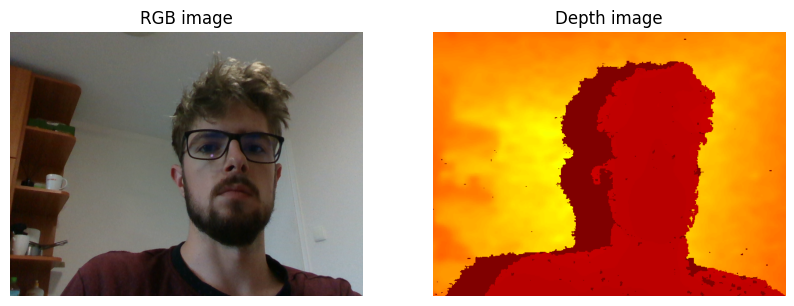

In [23]:
color_image = None
depth_image = None
depth_colormap = None

try:
    while True:
            for i in range(50): #kamera na początku pokazuje obraz w odcieniach niebieskich. Z czasem kolory poprawiają swoją barwę
                # Wait for a coherent pair of frames: depth and color
                frames = pipeline.wait_for_frames()
                aligned_frames = align.process(frames)
                
                depth_frame = aligned_frames.get_depth_frame()
                color_frame = aligned_frames.get_color_frame()
                if not depth_frame or not color_frame:
                    continue
                aligned_deapth_image = np.asanyarray(frames.get_depth_frame().get_data())

                # Convert images to numpy arrays
                depth_image = np.asanyarray(depth_frame.get_data())
                color_image = np.asanyarray(color_frame.get_data())
                color_image = cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB)

                # Apply colormap on depth image (image must be converted to 8-bit per pixel first)
                depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.033), cv2.COLORMAP_JET)

                depth_colormap_dim = depth_colormap.shape
                color_colormap_dim = color_image.shape

                # If depth and color resolutions are different, resize color image to match depth image for display
                if depth_colormap_dim != color_colormap_dim:
                    resized_color_image = cv2.resize(color_image, dsize=(depth_colormap_dim[1], depth_colormap_dim[0]), interpolation=cv2.INTER_AREA)
                    #images = np.hstack((resized_color_image, depth_colormap))
                #else:
                    #images = np.hstack((color_image, depth_colormap))


            # RGB i głębia
            plt.figure(figsize=(10,20))
            plt.subplot(1,2,1)
            plt.imshow(color_image)
            plt.title('RGB image')
            plt.axis('off')

            plt.subplot(1,2,2)
            plt.imshow(depth_colormap)
            plt.title('Depth image')
            plt.axis('off')
            #plt.legend()

            plt.show()
            break
finally:
    pass


## Modele YOLO


0: 480x640 1 person, 2 bottles, 2 cups, 759.1ms
Speed: 1.6ms preprocess, 759.1ms inference, 5.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 person, 1 bottle, 1 cup, 86.2ms
Speed: 1.6ms preprocess, 86.2ms inference, 4.2ms postprocess per image at shape (1, 3, 480, 640)


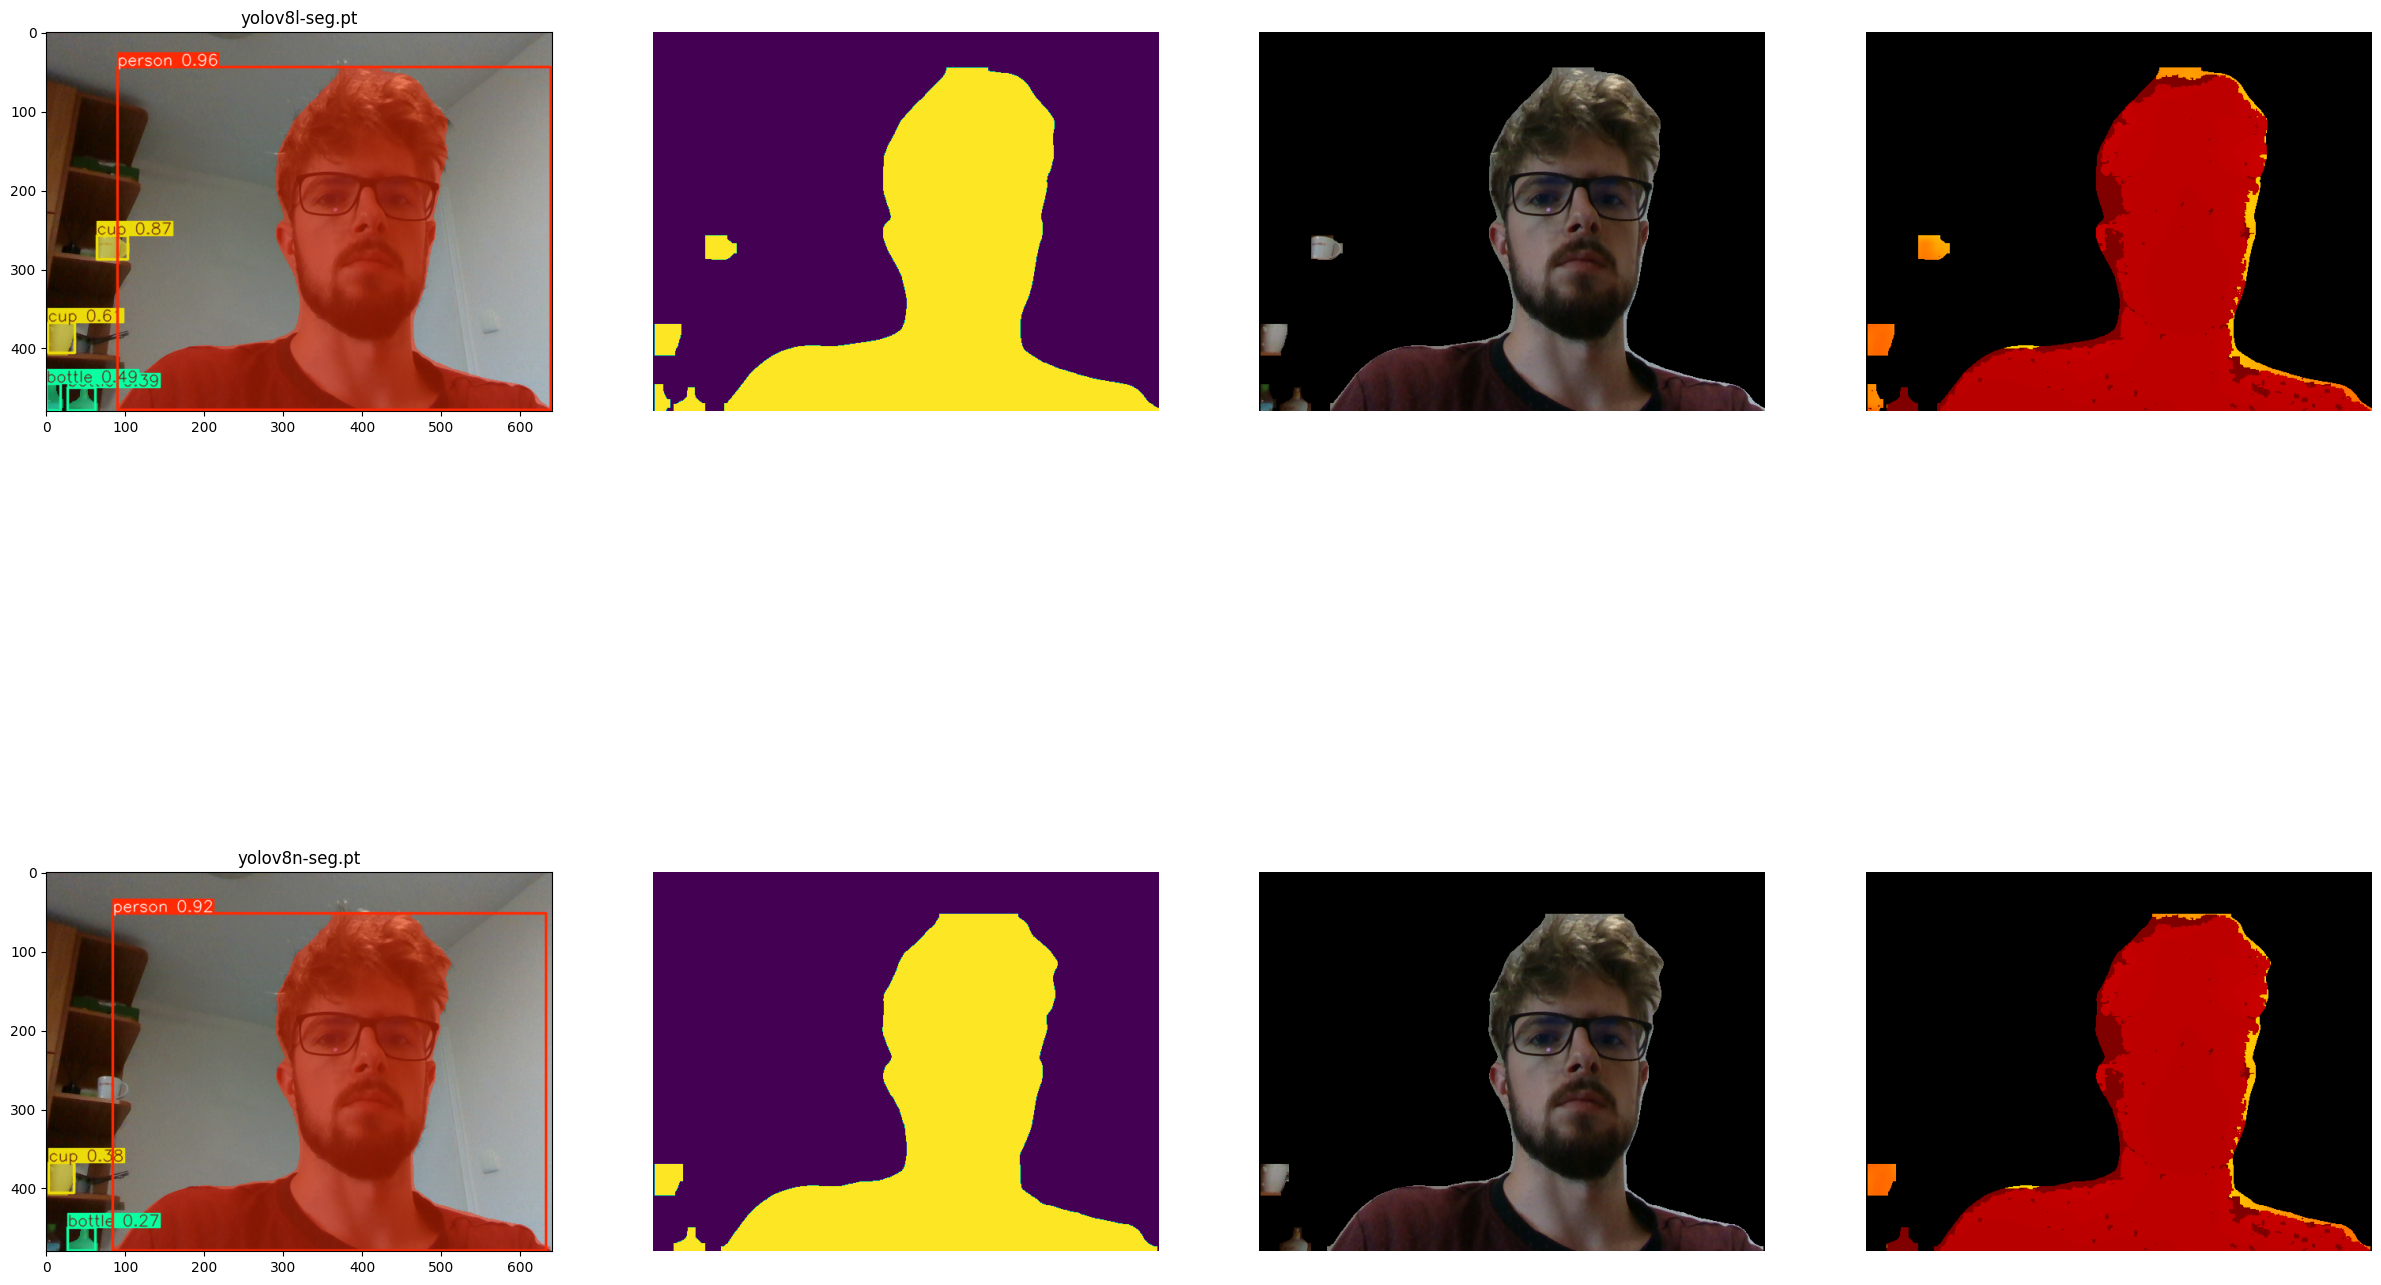

In [43]:
from ultralytics import YOLO
from ultralytics import SAM

models_YOLO = []

models_YOLO.append(YOLO('yolov8l-seg.pt'))
models_YOLO.append(YOLO('yolov8n-seg.pt'))
#models_YOLO.append(YOLO('yolov9c-seg.pt'))
#models_YOLO.append(YOLO('yolov9e-seg.pt'))
# models_YOLO.append(SAM('sam_b.pt'))
# models_YOLO.append(SAM('sam_l.pt'))


segmented_images_by_yolo = []
segmented_image_yolo_masks = []

for model in models_YOLO:
    output = model(color_image)
    segmented_images_by_yolo.append(output[0])
    segmented_image_yolo_masks.append(output[0].masks)

#MARK: Wizualizacja danych 

output_greed_size = (int(len(segmented_images_by_yolo)),4)
#print(output_greed_size)
plt.figure(figsize=(output_greed_size[0]*15, output_greed_size[1]*5))

for i in range(output_greed_size[0]):
    #print(i+1)
    plt.subplot(output_greed_size[0], output_greed_size[1], 4*i+1)
    plt.imshow(segmented_images_by_yolo[i].plot())
    plt.title(f'{models_YOLO[i].model_name}')
    plt.subplot(output_greed_size[0], output_greed_size[1], 4*i+2)
    masks = segmented_image_yolo_masks[i]
    mask_image = np.zeros((480, 640))
    
    for j in range(len(masks)):

        mask_image += masks.data[j].cpu().numpy().squeeze()
    plt.imshow(mask_image)
    plt.axis('off')

    masked_color_image = cv2.bitwise_and(color_image, color_image, mask = mask_image.astype(np.uint8))
    plt.subplot(output_greed_size[0], output_greed_size[1], 4*i+3)
    plt.imshow(masked_color_image)
    plt.axis('off')

    plt.subplot(output_greed_size[0], output_greed_size[1], 4*i+4)
    deapth_segmented = cv2.bitwise_and(depth_colormap, depth_colormap, mask = mask_image.astype(np.uint8))
    plt.imshow(deapth_segmented)
    plt.axis('off')

## Modele  Pytorch

Using cache found in /home/mikolaj/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/mikolaj/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/mikolaj/.cache/torch/hub/pytorch_vision_v0.10.0


Using device: cpu
(3, 4)
0
1
2


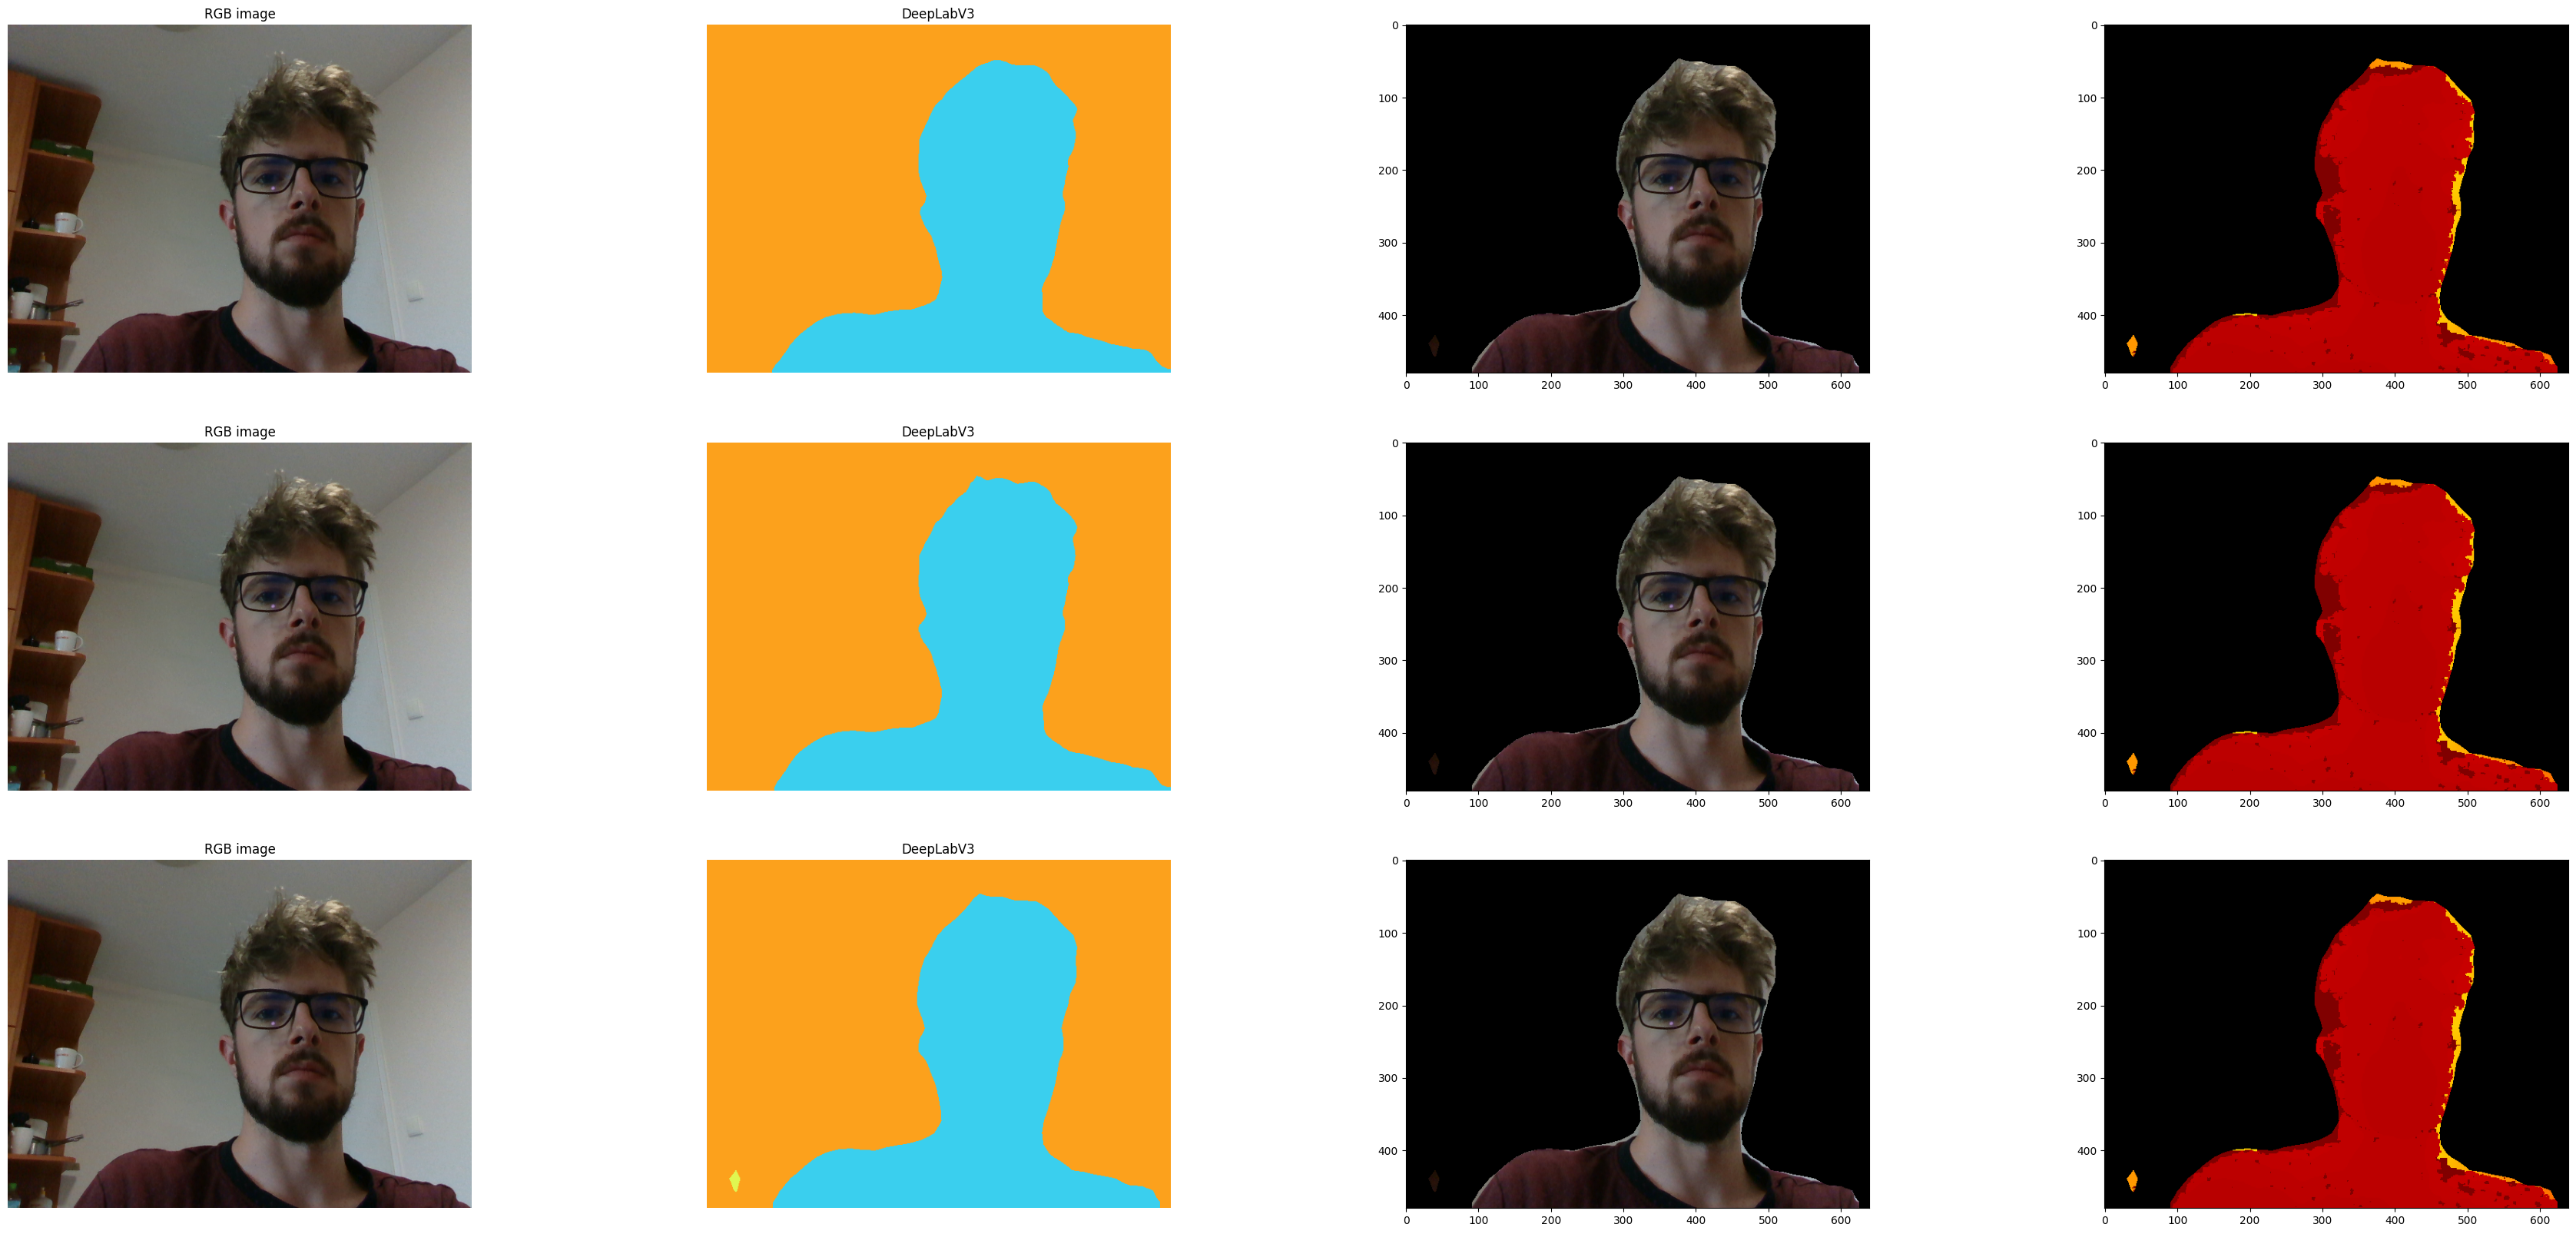

In [38]:
import torch
from torchvision import transforms

models_torch = []

models_torch.append(torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet101', pretrained=True))
models_torch.append(torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True))
models_torch.append(torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_mobilenet_v3_large', pretrained=True))



device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using device: {device}')

for model in models_torch:
    model.to(device)
    model.eval()

#MARK: Segmentacja semantyczna
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

color_image_tensor = preprocess(color_image)
color_image_tensor = color_image_tensor.unsqueeze(0)

colormap = np.random.randint(0,255,size = (150,3), dtype = np.uint8)
segmented_images_by_torch = []
for model in models_torch:
    with torch.no_grad():
        output = model(color_image_tensor)
        output = output['out'][0]
        output_predictions = output.argmax(0)
    output_predictions = output_predictions.byte().cpu().numpy()
    
    segmented_image = colormap[output_predictions%len(colormap)]
    segmented_image = cv2.cvtColor(segmented_image.astype(np.uint8), cv2.COLOR_RGB2BGR)
    segmented_images_by_torch.append(segmented_image)


output_greed_size = (int(len(segmented_images_by_torch)),4)
print(output_greed_size)

plt.figure(figsize=(output_greed_size[0]*15, output_greed_size[1]*5))

for i in range(output_greed_size[0]):
    print(i)
    plt.subplot(output_greed_size[0], output_greed_size[1], 4*i+1)
    plt.imshow(color_image)
    plt.title('RGB image')
    plt.axis('off')
    plt.subplot(output_greed_size[0], output_greed_size[1], 4*i+2)
    plt.imshow(segmented_images_by_torch[i])
    plt.title(f'{models_torch[i].__class__.__name__}')
    plt.axis('off')

    masked_image = cv2.bitwise_and(color_image, color_image, mask = output_predictions.astype(np.uint8))
    plt.subplot(output_greed_size[0], output_greed_size[1], 4*i+3)
    plt.imshow(masked_image)

    masked_deapth = cv2.bitwise_and(depth_colormap, depth_colormap, mask = output_predictions.astype(np.uint8))
    plt.subplot(output_greed_size[0], output_greed_size[1], 4*i+4)
    plt.imshow(masked_deapth)
    

plt.show()
    
    